# simulation_dev 

TODO: 

* Priority #1: 
    * Test to see if the peaks in Heather's plot are from sidebands. 
    * Steps: 
        1. Learn her method from her and winston. Run it on the data that matches (KrTest_04302021/I_side_LessCharged/Freq_data_2021-04-30-13-11-07.spec)
        2. Run her method on the same length of my own data until you start to get the event number right.
        3. Turn on sidebands and see what happens. 
* Priority #2: 
    * Fix the field profile pkl file name, and figure out if it is working like you expect it should work. It is very confusing how it all fits together but I need to be sure I understand how it fits together. 
* Freq Peaks rising above the noise. It looks like I see some peaks just from noise. See if these stay around when analyzing with Heather's technique. 
* Testing what I have: 
    * Running high level sanity checks for simple simulation settings. 
    * Writing sim_block level tests into the pytests section. Might wait to do this until things are working better, or the bigger fish have been fried.
* Add in a rng seed to config file. 
    * In order for this to work, every function that uses a random number generator will need to be fed that generator (that gets initialized with the seed in the config file). This may take some work but will be very important for making this simulation useful. 
* Add in the ability to specify a trap current in the config file as opposed to a relative trap strength. This will be easier to work with when comparing data to simulation. 
* Solve the discrepancy between our slopes and observed slopes. 
    * One simple test would be to see if our power calculation agrees with the value for theta = 90 of Ali's fig 3.8 at the end of chapter 3. 
* With extra time or when stuck. 
    * Document and organize the code you have so far. 
    * Get at least a few sanity checks working for both the block level and simulation level tests. This is very important. 
    * Post the playground to the spec sims slack channel so people can see progress. 
    * Rearrange the order of the tracks_df so that it makes more sense and is easier to read. 
    * Why do I have two pyinit files? Can I get rid of one of them?
    * If events_to_simulate = 0 then we get an error. Fix this with a helpful exception. 


## Checking on the power formulas: 

Notes: 
* Starting with comparing our formula to Fig 3.9 in Ali's thesis. 
* My pc formula has absolutely no trap radius dependence!!! MUST INVESTIGATE LOL


In [83]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks
import he6_cres_spec_sims.analysis.visualization as viz
import he6_cres_spec_sims.spec_tools.spec_calc.power_calc as pc
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc

## Working on improving my simulations based on meeting with Patrick: 

Tasks: 

1. Impliment a Results dataclass to collect all the dfs and then write them to disk somewhere. This Reslults class can also have a load and read functionality. Where you point it at a directory...

2. Make names more intuitive: EventBuilder, SegmentBuilder, BandBuilder, TrackBuilder, DMTrackBuilder,

### Constructing the Results class: 

* It will take the path to the config as it's argument. Then it will make a 

In [15]:
# Trying to use a dataclass: 
from dataclasses import dataclass
import pathlib
import inspect

config_path = pathlib.Path(r'/home/drew/He6CRES/simulation_results/config_example.json') 

@dataclass(frozen = True)
class Results:
    events: pd.DataFrame
    segments: pd.DataFrame
    bands: pd.DataFrame 
    
    def save(self, config_path):
        results_dict = {"events": self.events,
                        "segments": self.segments,
                        "bands": self.bands}
        
        # First make a results directory with the same name as the config.
        config_name = config_path.stem
        parent_dir = config_path.parents[0]
        results_dir = parent_dir / "{}".format(config_name)
        exists = results_dir.is_dir()

        # If results_dir doesn't exist, then create it.
        if not exists:
            results_dir.mkdir()
            print("created directory : ", results_dir)
        
        # Now write the results to results_dir: 
        for data_name, data in results_dict.items():
#             print(data_name, data)
                
            try: 
                data.to_csv(results_dir / "{}.csv".format(data_name))
            except Exception as e:
                print("Unable to write {} data.".format(data_name))
                raise e

    
    @classmethod
    def load(cls, config_path):
        results_dict = {"events": None,
                        "segments": None,
                        "bands": None}
        # Load results. 
        # First make a results directory with the same name as the config.
        config_name = config_path.stem
        parent_dir = config_path.parents[0]
        results_dir = parent_dir / "{}".format(config_name)
        
        for data_name, data in results_dict.items():

            try: 
                df = pd.read_csv(results_dir / "{}.csv".format(data_name),
            index_col=[0])
                results_dict[data_name] = df
                
            except Exception as e:
                print("Unable to load {} data.".format(data_name))
                raise e
                
        results = cls(results_dict["events"],results_dict["segments"],results_dict["bands"])
        
        return results

In [5]:
# list of strings
array = np.arange(3,13,1)
  
# Calling DataFrame constructor on list
df_1 = pd.DataFrame(array)
df_2 = pd.DataFrame(array)
df_3 = pd.DataFrame(array)

In [6]:
results = Results(df_1,df_2,df_3)
results.save(config_path)

In [7]:
results = Results.load(config_path)

print(results.events)

    0
0   3
1   4
2   5
3   6
4   7
5   8
6   9
7  10
8  11
9  12


In [57]:
config_path = pathlib.Path(r'/home/drew/He6CRES/simulation_results/config_example.yaml')

with config_path.open() as file:
    documents = yaml.full_load(file)

    for item, doc in documents.items():
        print(item, ":", doc)

Physics : {'events_to_simulate': 2, 'monoenergetic': True, 'energy': 1780.0, 'min_rho': 0.0, 'max_rho': 0.0, 'min_z': -0.005, 'max_z': 0.005, 'min_theta': 90.0, 'max_theta': 90.0}


In [85]:
config_path = pathlib.Path(r'/home/drew/He6CRES/simulation_results/config_example.yaml')

# config = sim_blocks.Config(config_path)

In [86]:
simulation = sim.Simulation(config_path)

coil current 0.24687194322084335 A
Optimization terminated successfully.
         Current function value: -1.000499
         Iterations: 42
         Function evaluations: 96
Trap width: (-0.04319392395019532,0.04319392395019532)
Maximum Field: 1.0004990411136685


In [87]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/1...

Trapped!

Event: 1/1...

Trapped!
~~~~~~~~~~~~Kinematics Block~~~~~~~~~~~~~~


Scattering Event : 0
Jump: 0
Trapped!
Jump: 1
Trapped!
Jump: 2
Trapped!
Event reached jump_num_max : 2

Scattering Event : 1
Jump: 0
Trapped!
Jump: 1
Trapped!
Jump: 2
Trapped!
Event reached jump_num_max : 2
~~~~~~~~~~~~BandBuilder Block~~~~~~~~~~~~~~

~~~~~~~~~~~~TrackBuilder Block~~~~~~~~~~~~~~

~~~~~~~~~~~~DownMixer Block~~~~~~~~~~~~~~

DownMixing the cyclotron frequency with a 17.9 GHz signal
~~~~~~~~~~~~Daq Block~~~~~~~~~~~~~~

Creating a spec_array with shape:  (915, 32768)

Allocating power to bins in spec_array for 42 tracks.

Gain was overidden with value: 1.0 

~~~~~~~~~~~~SpecBuilder Block~~~~~~~~~~~~~~


**Block Output:**
Successfully wrote a spec file to /home/drew/He6CRES/simulation_results/config_example/example_spec_file.spec 



In [88]:
simulation.run_daq()

~~~~~~~~~~~~Daq Block~~~~~~~~~~~~~~

Creating a spec_array with shape:  (915, 32768)

Allocating power to bins in spec_array for 42 tracks.

Gain was overidden with value: 1.0 

~~~~~~~~~~~~SpecBuilder Block~~~~~~~~~~~~~~


**Block Output:**
Successfully wrote a spec file to /home/drew/He6CRES/simulation_results/config_example/example_spec_file.spec 



In [89]:
results = sim.Results.load(config_path)

In [91]:
results.dmtracks

0     4.587943e-17
1     4.587943e-17
2     4.587943e-17
3     4.587943e-17
4     4.587943e-17
5     4.587943e-17
6     4.587943e-17
7     4.555396e-17
8     4.555396e-17
9     4.555396e-17
10    4.555396e-17
11    4.555396e-17
12    4.555396e-17
13    4.555396e-17
14    4.504241e-17
15    4.504241e-17
16    4.504241e-17
17    4.504241e-17
18    4.504241e-17
19    4.504241e-17
20    4.504241e-17
21    4.580593e-17
22    4.580593e-17
23    4.580593e-17
24    4.580593e-17
25    4.580593e-17
26    4.580593e-17
27    4.580593e-17
28    4.554219e-17
29    4.554219e-17
30    4.554219e-17
31    4.554219e-17
32    4.554219e-17
33    4.554219e-17
34    4.554219e-17
35    4.533785e-17
36    4.533785e-17
37    4.533785e-17
38    4.533785e-17
39    4.533785e-17
40    4.533785e-17
41    4.533785e-17
Name: segment_power, dtype: float64

In [95]:
config_path = pathlib.Path(r'/home/drew/He6CRES/simulation_results/config_example.yaml')

In [96]:
config = sim_blocks.Config(config_path)

coil current 0.24687194322084335 A
Optimization terminated successfully.
         Current function value: -1.000499
         Iterations: 42
         Function evaluations: 96
Trap width: (-0.04319392395019532,0.04319392395019532)
Maximum Field: 1.0004990411136685


In [107]:
## Import measured field: 

measured_field_real = pd.read_csv("/home/drew/Downloads/MeasuredField.csv")

measured_field_real
# plt.plot(measured_field["z"],measured_field["B"])

,z,B,uncertainty
0,0.0,0.341867,0.007227
1,5.0,0.501223,0.004060
2,10.0,0.752422,0.004060
3,15.0,1.195555,0.014453
4,20.0,2.005675,0.035758
5,25.0,3.587450,0.093214
6,30.0,6.699975,0.148269
7,35.0,12.249925,0.233496
8,40.0,18.408250,0.280301
9,42.5,19.939000,0.000000


In [99]:
# /home/drew/Downloads/simfield_1A_4.3S.csv
## Import measured field: 

measured_field = pd.read_csv("/home/drew/Downloads/simfield_1A.csv")

print(measured_field.shape)
plt.plot(measured_field["z"],measured_field["B"])

(1806, 2)


In [115]:
%matplotlib qt
z_vals = measured_field["z"]

simulated_field_strength = (config.field_strength(0,z_vals) - 1.000)*1/0.24687194322084335

print(simulated_field_strength.max())
# plt.plot(z_vals*1e3+86.88,simulated_field_strength*10000, label = "Simulation")
plt.plot(z_vals,simulated_field_strength*10000, label = " Python Simulation")
plt.plot(measured_field["z"],measured_field["B"], label = "Kasseoppia Simulation")
plt.plot(z_vals,measured_field["B"] -simulated_field_strength*10000, label = "Simulation Difference")
plt.plot(measured_field_real["z"]*1e-3-86.88e-3,measured_field_real["B"], "+" ,label = "Data")
plt.xlabel("m")
plt.ylabel("Gauss")
plt.title("Field Comparison: Python Sim vs RJ's Data for a 1A trap. ")
plt.legend()
plt.show()
print(z_vals)
print(z_vals.size)
print(measured_field["z"])
(z_vals,measured_field["B"] -simulated_field_strength*10000)[500:1300].mean()

0.0020214566869754215
0      -0.0995
1      -0.0994
2      -0.0993
3      -0.0992
4      -0.0991
         ...  
1801    0.0995
1802    0.0996
1803    0.0997
1804    0.0998
1805    0.0999
Name: z, Length: 1806, dtype: float64
1806
0      -0.0995
1      -0.0994
2      -0.0993
3      -0.0992
4      -0.0991
         ...  
1801    0.0995
1802    0.0996
1803    0.0997
1804    0.0998
1805    0.0999
Name: z, Length: 1806, dtype: float64


AttributeError: 'tuple' object has no attribute 'mean'

In [246]:
plt.plot(z_vals,(measured_field["B"] -simulated_field_strength*10000)/simulated_field_strength*10000)
plt.show()
# measured_field["B"] -simulated_field_strength*10000

### First verify that the slopes I'm seeing are consistent with what I get for a direct calculation.

In [3]:
config = sim_blocks.Config(config_filename = "test/simple_0")

energy = 17.83e3
# energy = 30.472e3
# center_field = config.field_strength(0,0)
center_field = 1
cyc_freq = sc.energy_to_freq( energy,center_field )
print(cyc_freq)

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139
27048694918.551296


In [118]:
%matplotlib qt
center_powers = []
slopes = []
rhos = np.arange(0,6e-3,.25e-3)
for rho in rhos:
    center_power = pc.power_calc(0, rho, cyc_freq, center_field, trap_radius=5.0e-3)
    center_powers.append(center_power)
    slope = sc.df_dt(energy, center_field, center_power*2)
    slopes.append(slope)

NameError: name 'cyc_freq' is not defined

In [69]:
plt.xlabel(r"$\rho$ (mm)")
plt.ylabel(r"Power (fW)")
plt.title(r"Power coupled into one side of WG")
plt.plot(rhos*1e3, np.array(center_powers)*1e15 )
plt.show()

In [71]:
plt.xlabel(r"$\rho$ (mm)")
plt.ylabel(r"Slope (Hz/s)")
plt.title(r"Slopes")
plt.plot(rhos*1e3, np.array(slopes) )
plt.show()

#### I am out of ideas for the moment. Moving on for now. 

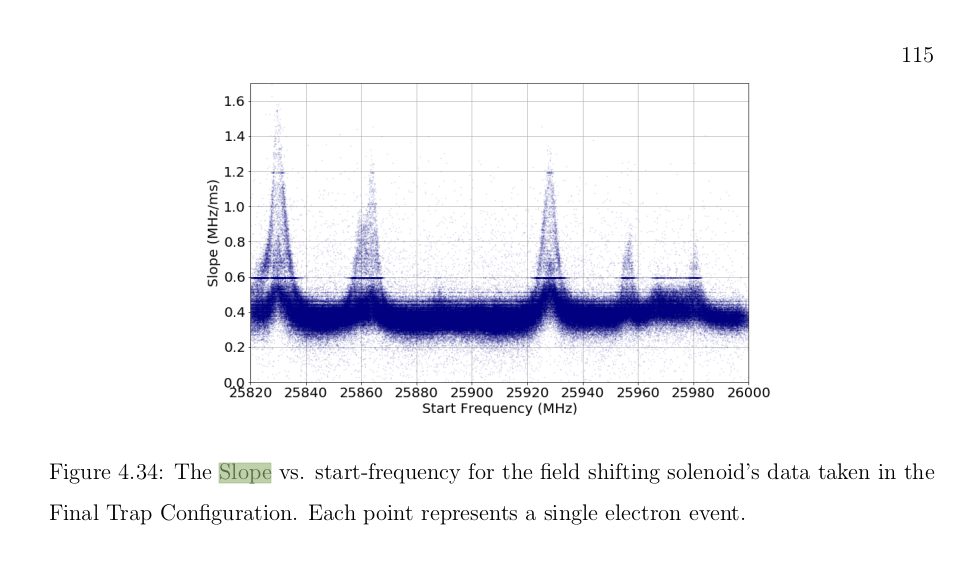

# Testing 

# Testing things on the whole: 

Note: Maybe build this into a sim_test.ipynb for illustrating that things make sense. 

## List of tests: 

1. 90 pich angle, z = 0, rho = 0. See what track powers end up as. 
    * Later: Use this as a calibration of the power in katydid, as well as to check the slopes. 
2. 90 pich angle, z = 0, rho = free.
    * Look at the spread in start frequencies and powers. Will this be an issue for us if we address the doppler?

In [9]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%autoreload 2
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks
import he6_cres_spec_sims.analysis.visualization as viz

import numpy as np
from numpy.random import default_rng
rng = default_rng(12345)

import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Test 0: 90 pitch angle, z = 0, rho = 0. No scattering.
config: test/simple_0.yaml

In [22]:
config = sim_blocks.Config(config_filename = "test/simple_0")

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


## Run the simulation based on the above config

In [23]:
simulation = sim.Simulation(config)

In [24]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/99...

Trapped!

Event: 1/99...

Trapped!

Event: 2/99...

Trapped!

Event: 3/99...

Trapped!

Event: 4/99...

Trapped!

Event: 5/99...

Trapped!

Event: 6/99...

Trapped!

Event: 7/99...

Trapped!

Event: 8/99...

Trapped!

Event: 9/99...

Trapped!

Event: 10/99...

Trapped!

Event: 11/99...

Trapped!

Event: 12/99...

Trapped!

Event: 13/99...

Trapped!

Event: 14/99...

Trapped!

Event: 15/99...

Trapped!

Event: 16/99...

Trapped!

Event: 17/99...

Trapped!

Event: 18/99...

Trapped!

Event: 19/99...

Trapped!

Event: 20/99...

Trapped!

Event: 21/99...

Trapped!

Event: 22/99...

Trapped!

Event: 23/99...

Trapped!

Event: 24/99...

Trapped!

Event: 25/99...

Trapped!

Event: 26/99...

Trapped!

Event: 27/99...

Trapped!

Event: 28/99...

Trapped!

Event: 29/99...

Trapped!

Event: 30/99...

Trapped!

Event: 31/99...

Trapped!

Event: 32/99...

Trapped!

Event: 33/99...

Trapped!

Event: 34/9

In [77]:
bands_df = viz.read_saved_df(config,"bandbuilder_bands_df")
bands_df[0:10]

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,30472.0,30469.925131,0.0,32.180258,0.0,90.0,354.960559,90.0,0.688311,0.000868,0.000076,0.000865,0.000868,87.771878,0.000868,1.818318e+10,1.818325e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341045e+08,0.000209,7.970150e-16,0.0,0.0,0.0
1,30472.0,30401.898697,0.0,93.680150,0.0,90.0,215.166496,90.0,0.688311,0.000868,0.000500,-0.000709,0.000868,87.771878,0.000868,1.818318e+10,1.818553e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341465e+08,0.007046,7.970150e-16,0.0,0.0,1.0
2,30472.0,30365.285470,0.0,149.709838,0.0,90.0,2.250421,90.0,0.688311,0.000868,-0.000034,0.000867,0.000868,87.771878,0.000868,1.818318e+10,1.818676e+10,5.036001e-09,4.348576e+07,0.000001,7.970150e-16,3.341691e+08,0.010726,7.970150e-16,0.0,0.0,2.0
3,30472.0,30304.235558,0.0,191.358600,0.0,90.0,45.528555,90.0,0.688311,0.000868,-0.000619,0.000608,0.000868,87.771878,0.000868,1.818318e+10,1.818881e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.342068e+08,0.016862,7.970150e-16,0.0,0.0,3.0
4,30472.0,30434.173477,0.0,129.580132,0.0,90.0,110.425922,90.0,0.688311,0.000868,-0.000813,-0.000303,0.000868,87.771878,0.000868,1.818318e+10,1.818445e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341266e+08,0.003802,7.970150e-16,0.0,0.0,4.0
5,30472.0,30334.152217,0.0,235.473308,0.0,90.0,255.298683,90.0,0.688311,0.000868,0.000839,-0.000220,0.000868,87.771878,0.000868,1.818318e+10,1.818781e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341883e+08,0.013855,7.970150e-16,0.0,0.0,5.0
6,30472.0,30383.933344,0.0,129.424303,0.0,90.0,105.901929,90.0,0.688311,0.000868,-0.000835,-0.000238,0.000868,87.771878,0.000868,1.818318e+10,1.818614e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341576e+08,0.008852,7.970150e-16,0.0,0.0,6.0
7,30472.0,30255.301890,0.0,95.388329,0.0,90.0,113.513218,90.0,0.688311,0.000868,-0.000796,-0.000346,0.000868,87.771878,0.000868,1.818318e+10,1.819046e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.342370e+08,0.021781,7.970150e-16,0.0,0.0,7.0
8,30472.0,30452.518231,0.0,336.918617,0.0,90.0,350.420465,90.0,0.688311,0.000868,0.000144,0.000856,0.000868,87.771878,0.000868,1.818318e+10,1.818383e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341153e+08,0.001958,7.970150e-16,0.0,0.0,8.0
9,30472.0,30426.682271,0.0,342.985765,0.0,90.0,228.492350,90.0,0.688311,0.000868,0.000650,-0.000575,0.000868,87.771878,0.000868,1.818318e+10,1.818470e+10,5.385559e-09,4.347147e+07,0.000001,7.970150e-16,3.341312e+08,0.004555,7.970150e-16,0.0,0.0,9.0


In [98]:

print("Mean track length (s): \nFrom df: ", bands_df["segment_length"].mean(), "\nFrom config: " ,config.kinematics.mean_track_length)

Mean track length (s): 
From df:  0.009297657713421531 
From config:  0.01


In [99]:
def column_all_same(df_column, rtol =1e-05 ):
    col = df_column.to_numpy() # df.values (pandas<0.24)
    return np.allclose(col[0], col, rtol)

data = []
for column in bands_df:
    data.append(column_all_same(bands_df[column]))

samenesss_df = pd.DataFrame([data], columns = bands_df.columns)

In [100]:
samenesss_df

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,True,False


In [88]:
bands_df.hist("slope")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd440aff50>]],
      dtype=object)

In [89]:
plt.plot(bands_df["segment_length"],bands_df["slope"])

# Test 1: 90 pitch angle, z = 0, rho = (0,5.78e-3). No scattering.
config: test/simple_1.yaml

In [94]:
config = sim_blocks.Config(config_filename = "test/simple_1")

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


## Run the simulation based on the above config

In [95]:
simulation = sim.Simulation(config)

In [96]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 1/99...

Trapped!

Event: 2/99...

Trapped!

Event: 3/99...

Trapped!

Event: 4/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 5/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 6/99...

Trapped!

Event: 7/99...

Trapped!

Event: 8/99...

Trapped!

Event: 9/99...

Trapped!

Event: 10/99...

Trapped!

Event: 11/99...

Trapped!

Event: 12/99...

Trapped!

Event: 13/99...

Not Trapped: Collided with guide wall.
Not Trapped: Collided with guide wall.
Trapped!

Event: 14/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 15/99...

Trapped!

Event: 16/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 17/99...

Trapped!

Event: 18/99...

Trapped!

Event: 19/99...

Trapped!

Event: 20/99...

Trapped!

Event: 21/99...

Trapped!

Event: 22/99...

Not Trapped: Collided with guide wall.
Trappe

In [97]:
bands_df = viz.read_saved_df(config,"bandbuilder_bands_df")
bands_df[0:10]

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,30472.0,30440.795669,0.004745,147.276048,0.0,90.0,153.408902,90.0,0.688248,0.000868,0.004357,-0.000776,0.004425,87.686587,0.000868,1.818179e+10,1.818284e+10,1.999378e-09,4.956712e+07,4.181453e-07,2.980042e-16,1.249190e+08,0.008388,2.980042e-16,0.0,0.0,0.0
1,30472.0,30467.111268,0.004693,127.207481,0.0,90.0,94.323511,90.0,0.688249,0.000868,0.003828,-0.000065,0.003829,87.709726,0.000868,1.818217e+10,1.818234e+10,1.334681e-09,4.793897e+07,2.791516e-07,3.848189e-16,1.613060e+08,0.001018,3.848189e-16,0.0,0.0,1.0
2,30472.0,30462.136507,0.004228,30.305395,0.0,90.0,105.276151,90.0,0.688262,0.000868,0.003391,-0.000229,0.003399,87.724009,0.000868,1.818241e+10,1.818274e+10,4.007994e-10,4.692414e+07,8.383169e-08,4.535011e-16,1.901000e+08,0.001742,4.535011e-16,0.0,0.0,2.0
3,30472.0,30389.814617,0.001260,76.532120,0.0,90.0,173.325714,90.0,0.688307,0.000868,0.001160,-0.000862,0.001445,87.766109,0.000868,1.818309e+10,1.818585e+10,4.232444e-09,4.390409e+07,8.853728e-07,7.444609e-16,3.121187e+08,0.008844,7.444609e-16,0.0,0.0,3.0
4,30472.0,30467.815612,0.002171,118.989786,0.0,90.0,209.814788,90.0,0.688298,0.000868,0.002602,-0.000753,0.002709,87.743014,0.000868,1.818271e+10,1.818286e+10,4.252222e-09,4.557143e+07,8.894497e-07,5.665831e-16,2.375036e+08,0.000592,5.665831e-16,0.0,0.0,4.0
5,30472.0,30442.293964,0.003418,297.006628,0.0,90.0,183.235490,90.0,0.688279,0.000868,0.003467,-0.000867,0.003574,87.718427,0.000868,1.818232e+10,1.818331e+10,3.986590e-09,4.731942e+07,8.338260e-07,4.251333e-16,1.782143e+08,0.005598,4.251333e-16,0.0,0.0,5.0
6,30472.0,30471.136736,0.004817,111.760361,0.0,90.0,55.304671,90.0,0.688246,0.000868,0.004103,0.000494,0.004133,87.698420,0.000868,1.818199e+10,1.818202e+10,5.676056e-09,4.874697e+07,1.187120e-06,3.389486e-16,1.420759e+08,0.000204,3.389486e-16,0.0,0.0,6.0
7,30472.0,30413.209469,0.004709,60.373375,0.0,90.0,148.571258,90.0,0.688249,0.000868,0.004257,-0.000741,0.004321,87.690937,0.000868,1.818186e+10,1.818384e+10,3.832930e-09,4.926058e+07,8.016209e-07,3.122676e-16,1.309052e+08,0.015082,3.122676e-16,0.0,0.0,7.0
8,30472.0,30375.780877,0.003079,225.880038,0.0,90.0,140.390103,90.0,0.688286,0.000868,0.002526,-0.000669,0.002613,87.745296,0.000868,1.818275e+10,1.818598e+10,1.018123e-09,4.539619e+07,2.129652e-07,5.820323e-16,2.440216e+08,0.013243,5.820323e-16,0.0,0.0,8.0
9,30472.0,30461.295637,0.002547,203.674082,0.0,90.0,216.055496,90.0,0.688294,0.000868,0.003058,-0.000702,0.003137,87.731771,0.000868,1.818253e+10,1.818289e+10,1.937596e-09,4.637586e+07,4.052791e-07,4.964655e-16,2.081117e+08,0.001727,4.964655e-16,0.0,0.0,9.0


In [101]:
print("Mean track length (s): \nFrom df: ", bands_df["segment_length"].mean(), "\nFrom config: " ,config.kinematics.mean_track_length)

Mean track length (s): 
From df:  0.009297657713421531 
From config:  0.01


In [109]:
def column_all_same(df_column, rtol =1e-03 ):
    col = df_column.to_numpy() # df.values (pandas<0.24)
    return np.allclose(col[0], col, rtol)

data = []
for column in bands_df:
    data.append(column_all_same(bands_df[column]))

samenesss_df = pd.DataFrame([data], columns = bands_df.columns)

In [110]:
samenesss_df

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,True,False,False,False,True,True,False,True,True,True,False,False,False,True,True,True,True,True,False,False,True,False,False,True,True,True,False


In [137]:
# Investigate the spread caused by rho:
bands_df.hist("avg_cycl_freq")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd3c4c2a10>]],
      dtype=object)

In [127]:
plt.plot(bands_df["slope"],bands_df["band_power"])

# Test 2: 90 initial pitch angle, z = (-5e3,5e3), rho = (0,5.78e-3). No scattering.
config: test/simple_2.yaml

In [113]:
config = sim_blocks.Config(config_filename = "test/simple_2")

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


## Run the simulation based on the above config

In [114]:
simulation = sim.Simulation(config)

In [115]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/99...

Trapped!

Event: 1/99...

Trapped!

Event: 2/99...

Trapped!

Event: 3/99...

Trapped!

Event: 4/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 5/99...

Trapped!

Event: 6/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 7/99...

Trapped!

Event: 8/99...

Trapped!

Event: 9/99...

Trapped!

Event: 10/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 11/99...

Trapped!

Event: 12/99...

Trapped!

Event: 13/99...

Trapped!

Event: 14/99...

Not Trapped: Collided with guide wall.
Not Trapped: Collided with guide wall.
Trapped!

Event: 15/99...

Trapped!

Event: 16/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 17/99...

Trapped!

Event: 18/99...

Trapped!

Event: 19/99...

Trapped!

Event: 20/99...

Trapped!

Event: 21/99...

Not Trapped: Collided with guide wall.
Trapped!

Event: 22/99...

Trapped!

Event: 23/99...

Trapped!

Event: 2

In [116]:
bands_df = viz.read_saved_df(config,"bandbuilder_bands_df")
bands_df[0:10]

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,30472.0,30434.002286,0.000889,194.036867,0.002482,90.0,347.920089,89.610898,0.688340,0.000868,0.001071,0.000849,0.001367,87.801210,0.000868,1.818353e+10,1.818480e+10,0.002482,4.285236e+07,0.519207,7.526186e-16,3.155208e+08,0.004044,6.561759e-16,0.0,0.0,0.0
1,30472.0,30360.368385,0.000155,336.719909,0.001293,90.0,278.762116,89.796232,0.688319,0.000868,0.001013,0.000132,0.001021,87.779955,0.000868,1.818327e+10,1.818702e+10,0.001293,4.331008e+07,0.270525,7.852364e-16,3.292353e+08,0.011389,7.568947e-16,0.0,0.0,1.0
2,30472.0,30410.695555,0.003209,272.391951,-0.004172,90.0,76.748229,89.346966,0.688378,0.000868,0.002364,0.000199,0.002373,87.847432,0.000868,1.818406e+10,1.818612e+10,0.004172,4.214234e+07,0.872852,6.189442e-16,2.594991e+08,0.007935,4.145679e-16,0.0,0.0,2.0
3,30472.0,30468.911200,0.004424,222.874541,-0.002056,90.0,27.319321,89.640696,0.688285,0.000868,0.004026,0.000771,0.004099,87.727944,0.000868,1.818237e+10,1.818247e+10,0.002056,4.786289e+07,0.430047,3.437667e-16,1.440991e+08,0.000720,3.130621e-16,0.0,0.0,3.0
4,30472.0,30431.223871,0.003756,29.922595,0.004022,90.0,350.853202,89.323167,0.688366,0.000868,0.003894,0.000857,0.003987,87.805947,0.000868,1.818339e+10,1.818476e+10,0.004022,4.530387e+07,0.841482,3.601478e-16,1.509846e+08,0.009070,2.484999e-16,0.0,0.0,4.0
5,30472.0,30458.701401,0.002778,163.149254,-0.000413,90.0,274.593731,89.928768,0.688291,0.000868,0.003643,0.000070,0.003643,87.717228,0.000868,1.818229e+10,1.818274e+10,0.000413,4.747301e+07,0.086419,4.139769e-16,1.735321e+08,0.002573,4.124332e-16,0.0,0.0,5.0
6,30472.0,30454.385595,0.003257,226.955873,0.000634,90.0,355.129245,89.891836,0.688285,0.000868,0.003331,0.000865,0.003442,87.725243,0.000868,1.818242e+10,1.818301e+10,0.000634,4.696446e+07,0.132609,4.465190e-16,1.871760e+08,0.003160,4.426058e-16,0.0,0.0,6.0
7,30472.0,30400.729270,0.002611,17.392397,0.000071,90.0,240.304153,89.987871,0.688293,0.000868,0.003365,-0.000430,0.003392,87.724253,0.000868,1.818241e+10,1.818480e+10,0.000071,4.691734e+07,0.014892,4.546209e-16,1.905910e+08,0.012559,4.545705e-16,0.0,0.0,7.0
8,30472.0,30471.655624,0.004032,103.310345,-0.000528,90.0,224.469101,89.903607,0.688268,0.000868,0.004640,-0.000619,0.004681,87.677453,0.000868,1.818163e+10,1.818165e+10,0.000528,5.029138e+07,0.110360,2.653294e-16,1.112149e+08,0.000104,2.637173e-16,0.0,0.0,8.0
9,30472.0,30418.779181,0.000086,134.821019,-0.003763,90.0,238.216903,89.425201,0.688379,0.000868,0.000823,-0.000457,0.000942,87.846666,0.000868,1.818411e+10,1.818589e+10,0.003763,4.133181e+07,0.787409,7.909168e-16,3.315965e+08,0.005391,5.726491e-16,0.0,0.0,9.0


In [117]:
print("Mean track length (s): \nFrom df: ", bands_df["segment_length"].mean(), "\nFrom config: " ,config.kinematics.mean_track_length)

Mean track length (s): 
From df:  0.008811859113987403 
From config:  0.01


In [118]:
def column_all_same(df_column, rtol =1e-03 ):
    col = df_column.to_numpy() # df.values (pandas<0.24)
    return np.allclose(col[0], col, rtol)

data = []
for column in bands_df:
    data.append(column_all_same(bands_df[column]))

samenesss_df = pd.DataFrame([data], columns = bands_df.columns)

In [119]:
samenesss_df

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,True,True,False,False,False,True,False,False,True,True,True,False


In [120]:
bands_df.hist("mod_index")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd5a753a90>]],
      dtype=object)

In [124]:
plt.plot(bands_df["slope"],bands_df["band_power"], "bo")

# Test 3:  initial pitch angle = (85,90], z = (-5e3,5e3), rho = (0,5.78e-3). No scattering.
config: test/simple_3.yaml

In [141]:
config = sim_blocks.Config(config_filename = "test/simple_3")

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139


## Run the simulation based on the above config

In [142]:
simulation = sim.Simulation(config)

In [143]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/99...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

Event: 1/99...

Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

Event: 2/99...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

Event: 3/99...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

Event: 4/99...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

Event: 5/99...

Not Trapped: Pitch angle too small.
Trapped!

E

In [131]:
bands_df = viz.read_saved_df(config,"bandbuilder_bands_df")
bands_df[0:10]

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,30472.0,30371.677938,0.003093,110.327897,0.0,89.552660,46.573041,89.552660,0.688285,0.000868,0.002462,0.000597,0.002534,87.747108,0.000868,1.818334e+10,1.818671e+10,0.002774,4.397528e+07,0.580334,5.942976e-16,2.491740e+08,0.013523,5.003477e-16,0.0,0.0,0.0
1,30472.0,30426.907955,0.000513,44.969855,0.0,89.736431,133.136354,89.736431,0.688310,0.000868,-0.000120,-0.000593,0.000605,87.773534,0.000868,1.818340e+10,1.818491e+10,0.001686,4.291856e+07,0.352619,8.126884e-16,3.407059e+08,0.004445,7.633281e-16,0.0,0.0,1.0
2,30472.0,30399.580659,0.003493,305.457075,0.0,88.902712,254.588620,88.902712,0.688278,0.000868,0.004329,-0.000231,0.004335,87.690334,0.000868,1.818555e+10,1.818798e+10,0.006991,4.001224e+07,1.463093,3.091513e-16,1.296284e+08,0.018766,8.760274e-17,0.0,0.0,2.0
3,30472.0,30458.761717,0.003862,151.868508,0.0,89.247944,165.919204,89.247944,0.688270,0.000868,0.003651,-0.000842,0.003746,87.712609,0.000868,1.818385e+10,1.818430e+10,0.004584,4.386736e+07,0.958986,3.970526e-16,1.664520e+08,0.002671,2.434091e-16,0.0,0.0,3.0
4,30472.0,30406.870297,0.004349,231.981355,0.0,88.823379,101.131788,88.823379,0.688258,0.000868,0.003498,-0.000168,0.003502,87.720754,0.000868,1.818671e+10,1.818890e+10,0.008128,3.611979e+07,1.701487,4.349091e-16,1.823683e+08,0.011997,6.858899e-17,0.0,0.0,4.0
5,30472.0,30453.036981,0.003445,251.518585,0.0,89.799412,248.373248,89.799412,0.688279,0.000868,0.004252,-0.000320,0.004264,87.693242,0.000868,1.818201e+10,1.818265e+10,0.001129,4.887360e+07,0.236030,3.201590e-16,1.342046e+08,0.004745,3.113336e-16,0.0,0.0,5.0
6,30472.0,30462.880422,0.003557,16.329674,0.0,89.000289,288.430378,89.000289,0.688277,0.000868,0.004381,0.000274,0.004389,87.688108,0.000868,1.818482e+10,1.818512e+10,0.006168,4.207783e+07,1.290766,3.020301e-16,1.266225e+08,0.002419,1.179416e-16,0.0,0.0,6.0
7,30472.0,30331.378531,0.003038,314.018205,0.0,89.024687,81.533363,89.024687,0.688286,0.000868,0.002180,0.000128,0.002184,87.754397,0.000868,1.818576e+10,1.819048e+10,0.006694,3.778882e+07,1.400899,6.463537e-16,2.710559e+08,0.017429,2.073324e-16,0.0,0.0,7.0
8,30472.0,30445.605553,0.001686,248.978011,0.0,88.466011,226.238767,88.466011,0.688303,0.000868,0.002313,-0.000600,0.002390,87.750248,0.000868,1.819140e+10,1.819229e+10,0.013919,2.353095e+07,2.916197,6.120726e-16,2.567053e+08,0.003455,3.247604e-17,0.0,0.0,8.0
9,30472.0,30419.199047,0.002204,161.289057,0.0,88.511893,346.385444,88.511893,0.688298,0.000868,0.002408,0.000843,0.002552,87.746701,0.000868,1.819065e+10,1.819242e+10,0.012879,2.542824e+07,2.697938,5.873533e-16,2.463397e+08,0.007201,1.176649e-17,0.0,0.0,9.0


In [132]:
print("Mean track length (s): \nFrom df: ", bands_df["segment_length"].mean(), "\nFrom config: " ,config.kinematics.mean_track_length)

Mean track length (s): 
From df:  0.009455187194232613 
From config:  0.01


In [133]:
def column_all_same(df_column, rtol =1e-03 ):
    col = df_column.to_numpy() # df.values (pandas<0.24)
    return np.allclose(col[0], col, rtol)

data = []
for column in bands_df:
    data.append(column_all_same(bands_df[column]))

samenesss_df = pd.DataFrame([data], columns = bands_df.columns)

In [134]:
samenesss_df

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,True,False,False,False,True,False,False,False,True,True,False,False,False,True,True,False,True,False,False,False,True,False,False,True,True,True,False


In [135]:
bands_df.hist("mod_index")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd3d554fd0>]],
      dtype=object)

In [136]:
plt.plot(bands_df["slope"],bands_df["band_power"], "bo")

In [2]:
%load_ext autoreload

In [198]:
%autoreload 2
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks
import he6_cres_spec_sims.analysis.visualization as viz

import numpy as np
from numpy.random import default_rng
rng = default_rng(12345)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt
plt.rcParams.update({'font.size': 26})
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Test 4: Attempting to create more realistic data so that I can calibrate the gain axis roughly. And test to see if we should expect to see sidebands

initial pitch angle = (85,90], z = (-5e3,5e3), rho = (0,5.78e-3). No scattering.
config: test/realistic_0.yaml
spec: realistic_0.yaml

Notes: 

* Ok I am going to need to sharpen up my katydid and root chops in order to really do this. 
* Ok I saw it crash for some reason. A division by zero after a bunch of scattering. Not sure what is causing this.
    * This error has to do with the trap condition being set to true but then a function like avg_cycl_freq or something seeing that in fact the elctron is not trapped. Need to investigate. SOLVED. 
* With sidebands it's just too confusing. So I'm going to keep it close to rho = 0
* Issue with the trap depth being written to csv.

In [298]:
config = sim_blocks.Config(config_filename = "test/realistic_0")

coil current 0.6042729229644659 A
Optimization terminated successfully.
         Current function value: -0.692689
         Iterations: 42
         Function evaluations: 93
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.692688548599168


In [70]:
print((config.field_strength(0,0)-config.hardware.main_field)/config.hardware.main_field)
# config.hardware.main_field

-0.003539999718780831


In [245]:
print(config.field_strength(0,0))
print(config.field_strength(5e-3,0))

0.6846421568172186
0.6843917231731217


## Calculate the desired field based on the data: 

In [ ]:
## Using the L_prime and K lines seemed to be problematic. Why is this? 

In [ ]:
main_field = 0.684362968

In [109]:
mean_field_list = np.array([0.68465074, 0.68555997, 0.68900671])
mean_field_list

array([0.68465074, 0.68555997, 0.68900671])

In [163]:
field_list_config = mean_field_list+ 3.54e-3*mean_field_list
field_list_config

array([0.6870744 , 0.68798685, 0.69144579])

In [133]:
min_field_sim = config.field_strength(0,0)
min_field_sim

array(0.6846432)

In [90]:
min_field_real = field_list_L_prime[0]
min_field_sim = config.field_strength(0,0)
min_field_sim = 0.684547904229688
set_field = config.hardware.main_field

print("desired min field: ", min_field_real, "\nsimulated min field: " ,min_field_sim)
print("current set field: ", set_field)
difference = min_field_sim - min_field_real

new_set_field = set_field - difference

print("new set field:" , new_set_field)

desired min field:  0.6846265198281077 
simulated min field:  0.684547904229688
current set field:  0.687
new set field: 0.6870786155984198


file:///home/drew/Downloads/image%20(7).png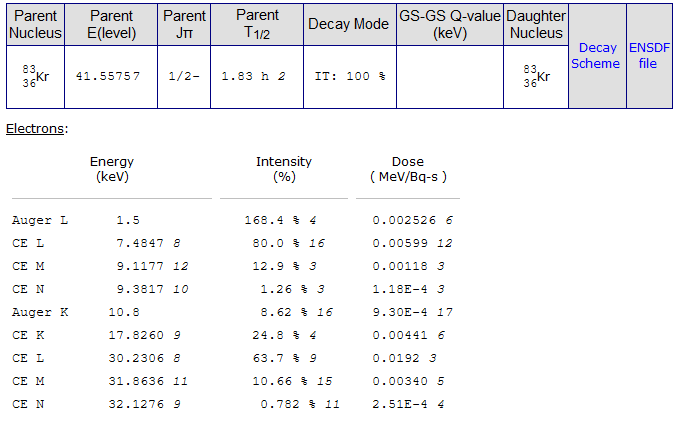

## Run the simulation based on the above config

In [299]:
simulation = sim.Simulation(config)

In [300]:
simulation.run_full()

~~~~~~~~~~~~Hardware Block~~~~~~~~~~~~~~

Constructing a set of trapped events:

Event: 0/0...

beta rho position 0.0
Trapped!

**Block Output:**
hardware_trapped_events_df written to /he6_cres_spec_sims/simulation_results/exploratory

~~~~~~~~~~~~Kinematics Block~~~~~~~~~~~~~~


Scattering Event : 0
Jump: 0
Trapped!
Event reached jump_num_max : 0

**Block Output:**
kinematics_segments_df written to /he6_cres_spec_sims/simulation_results/exploratory

~~~~~~~~~~~~BandBuilder Block~~~~~~~~~~~~~~


**Block Output:**
bandbuilder_bands_df written to /he6_cres_spec_sims/simulation_results/exploratory

~~~~~~~~~~~~TrackBuilder Block~~~~~~~~~~~~~~


**Block Output:**
trackbuilder_tracks_df written to /he6_cres_spec_sims/simulation_results/exploratory

~~~~~~~~~~~~DownMixer Block~~~~~~~~~~~~~~

DownMixing the cyclotron frequency with a 17.9 GHz signal

**Block Output:**
downmixer_downmixed_tracks_df written to /he6_cres_spec_sims/simulation_results/exploratory

~~~~~~~~~~~~Daq Block~~~~~~~~~~~~

In [301]:
bands_df = viz.read_saved_df(config,"bandbuilder_bands_df")
bands_df[0:10]

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.808852e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,4.691952e-17,-3.0,0.0,0.0
1,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.813724e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,1.717450e-16,-2.0,0.0,0.0
2,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.818597e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,1.699749e-16,-1.0,0.0,0.0
3,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.823470e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,1.032280e-17,0.0,0.0,0.0
4,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.828342e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,1.699749e-16,1.0,0.0,0.0
5,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.833215e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,1.717450e-16,2.0,0.0,0.0
6,30230.6,30215.362481,0.0,166.298377,0.0,87.3,199.912493,87.3,0.688998,0.000862,0.000294,-0.000811,0.000862,85.807912,0.000863,1.838087e+10,1.823521e+10,0.012483,4.872550e+07,2.635893,8.009967e-16,3.368833e+08,0.001524,4.691952e-17,3.0,0.0,0.0


In [54]:
print("Mean track length (s): \nFrom df: ", bands_df["segment_length"].mean(), "\nFrom config: " ,config.kinematics.mean_track_length)

Mean track length (s): 
From df:  0.004395652142385106 
From config:  0.005


In [149]:
def column_all_same(df_column, rtol =1e-03 ):
    col = df_column.to_numpy() # df.values (pandas<0.24)
    return np.allclose(col[0], col, rtol)

data = []
for column in bands_df:
    data.append(column_all_same(bands_df[column]))

samenesss_df = pd.DataFrame([data], columns = bands_df.columns)

In [150]:
samenesss_df

,energy,energy_stop,initial_rho_pos,initial_phi_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,rho_center,trapped_initial_pitch_angle,max_radius,avg_cycl_freq,freq_stop,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,True,True,False,False,False,True,False,False,True,True,True,False


In [53]:
%matplotlib qt
plt.hist(bands_df["avg_cycl_freq"]-17.9e9)

(array([ 0.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.]),
 array([2.83177799e+08, 2.83177799e+08, 2.83177799e+08, 2.83177799e+08,
        2.83177800e+08, 2.83177800e+08, 2.83177800e+08, 2.83177800e+08,
        2.83177800e+08, 2.83177800e+08, 2.83177800e+08]),
 <a list of 10 Patch objects>)

# Test 5: Making a very simple fake spec file to investigate the issue with Katydid timing. 

In [100]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
%autoreload 2
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks
import he6_cres_spec_sims.analysis.visualization as viz

import numpy as np
from numpy.random import default_rng
rng = default_rng(12345)

import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [102]:
config = sim_blocks.Config(config_filename = "test/realistic_0")

coil current 0.6004575426085468 A
Optimization terminated successfully.
         Current function value: -0.688315
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6883149118190688


In [103]:
B_min = config.field_strength(0,0) 
B_max = config.field_strength(0, .045156887)
(.68666-B_min)/.68666

.004*.6/.678068

0.0035394680179569008

## Run the simulation based on the above config

In [83]:
specbuilder = sim_blocks.SpecBuilder(config)

(500, 32768)
0.0030517578125 (32768,)


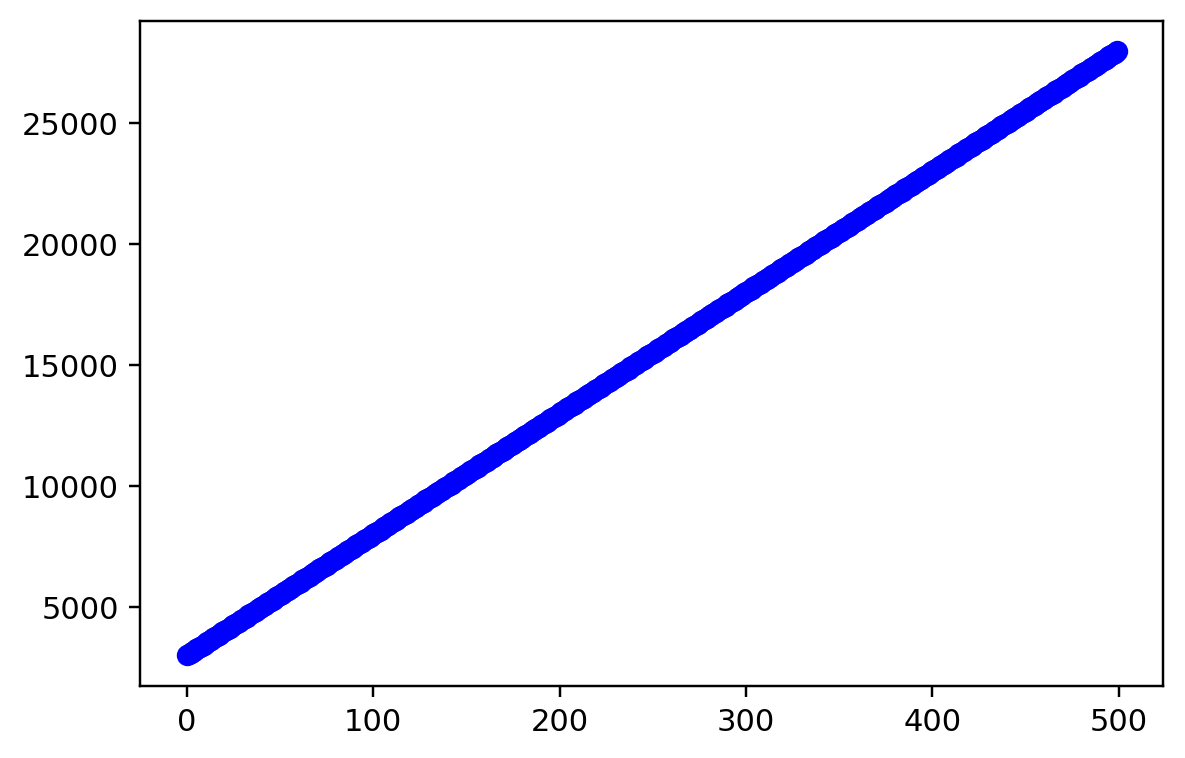

In [74]:
daq_freqbw = config.daq.daq_freqbw
freq_bins = config.daq.freq_bins
fft_per_slice = config.daq.fft_per_slice
run_length = .1

# Start by making the grid in freq and time
freq_per_bin = daq_freqbw / freq_bins

time_per_slice = fft_per_slice / freq_per_bin
time_slices = int(run_length / time_per_slice)

time_slices = 500
# # Should be almost identical to run_length but a multiple of time_per_slice.
# spec_time_stop = time_slices * time_per_slice

# t_ticks = np.arange(0, spec_time_stop + 1 * time_per_slice, time_per_slice)
# f_ticks = np.arange(0, daq_freqbw + 1 * freq_per_bin, freq_per_bin)

spec_array = np.zeros((time_slices, freq_bins))
print(spec_array.shape)
for i in range(0,time_slices,1):
#     print(i)
    spec_array[i][3000+50*i] = 100

plt.plot(np.nonzero(spec_array)[0],np.nonzero(spec_array)[1], "bo")

print(spec_array[0].mean(), spec_array[0].shape )

In [75]:
specbuilder.build_spec_file(spec_array)

~~~~~~~~~~~~SpecBuilder Block~~~~~~~~~~~~~~


**Block Output:**
Successfully wrote a spec file to /home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/simulation_results/sim_tests/spec_files/timing_test_0.spec 



## Can the LMN

In [3]:
%load_ext autoreload

In [40]:
%autoreload 2
import he6_cres_spec_sims.simulation as sim
import he6_cres_spec_sims.simulation_blocks as sim_blocks
import he6_cres_spec_sims.analysis.visualization as viz

import numpy as np
from numpy.random import default_rng
rng = default_rng(12345)

import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [44]:
config = sim_blocks.Config(config_filename = "test/realistic_0")

coil current 0.6000904934033661  A
trap strength 0.00354
main field 0.68666
trap strength 0.00354
main field 0.68666
Optimization terminated successfully.
         Current function value: -0.687894
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.687894156939049


In [42]:
B_min = config.field_strength(0,0) 
B_max = config.field_strength(0, .045156887)
(.68666-B_min)/.68666

.004*.6/.678068

0.0035394680179569008